In [53]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from patsy.highlevel import dmatrices

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

In [2]:
def get_cleaned_data(src: str) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    df = pd.read_csv(src)
    
    # Filter the data for:
    #
    working_sample = df[['id','name','host_id','host_name','host_since','host_is_superhost','host_listings_count','host_total_listings_count','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms_text','beds','price','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','reviews_per_month']][(df['price'].notna()) 
                        & (df['beds'].notna())
                        & (df['host_is_superhost'].notna())
                        & (df['bathrooms_text'].notna())
                        & (df['accommodates'] <= 6) & (df['accommodates'] >= 2)
                        & (df['neighbourhood_cleansed'].isin(['Palermo', 'Catania', 'Gravina di Catania', 'San Gregorio di Catania', 'Militello in Val di Catania', 'Messina', 'Taormina', 'Realmonte', 'Agrigento', 'Siracusa', 'Cefal', 'Monreale', 'Ragusa', 'Modica']))]
    
    # add boolean variables from text columns
    working_sample['d_host_is_superhost'] = working_sample['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_has_profile_pic'] = working_sample['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_identity_verified'] = working_sample['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_instant_bookable'] = working_sample['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    
    # calculate host time
    working_sample['n_host_since'] = working_sample['host_since'].apply(lambda x: (pd.Timestamp('2024-02-02') - pd.Timestamp(x)).days)
    
    # convert price to numerical
    working_sample['price'] = working_sample['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # filter for price < 
    working_sample = working_sample[(working_sample['price'] <= 400)]
    
    # fill NA data for reviews with 0s
    working_sample.fillna(0, inplace=True)
    
    # add numerical variable for number of bath
    working_sample['n_bathrooms'] = working_sample['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.lower().split()[0]))
    
    # rename numerical and categorical columns to have prefix
    working_sample.rename(columns={
        # 'host_listings_count': 'n_host_listings_count',
        # 'host_total_listings_count': 'n_host_total_listings_count',
        'accommodates': 'n_accommodates',
        'beds': 'n_beds',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        # new apartment not on market so no need to care about reviews
        # 'number_of_reviews': 'n_number_of_reviews',
        # 'reviews_per_month': 'n_reviews_per_month',
        # 'review_scores_rating': 'n_review_scores_rating',
        # 'review_scores_accuracy': 'n_review_scores_accuracy',
        # 'review_scores_cleanliness': 'n_review_scores_cleanliness',
        # 'review_scores_checkin': 'n_review_scores_checkin',
        # 'review_scores_communication': 'n_review_scores_communication',
        # 'review_scores_location': 'n_review_scores_location',
        # 'review_scores_value': 'n_review_scores_value',
        'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
        'property_type': 'f_property_type',
        'room_type': 'f_room_type'
    }, inplace=True)
    
    del df
    
    return working_sample

In [3]:
work_df = get_cleaned_data('listings.csv')
# test_df = get_cleaned_data('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings.csv')
work_df.shape

(17689, 35)

In [4]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17689 entries, 1 to 56682
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           17689 non-null  int64  
 1   name                         17689 non-null  object 
 2   host_id                      17689 non-null  int64  
 3   host_name                    17689 non-null  object 
 4   host_since                   17689 non-null  object 
 5   host_is_superhost            17689 non-null  object 
 6   host_listings_count          17689 non-null  int64  
 7   host_total_listings_count    17689 non-null  int64  
 8   host_has_profile_pic         17689 non-null  object 
 9   host_identity_verified       17689 non-null  object 
 10  f_neighbourhood_cleansed     17689 non-null  object 
 11  f_property_type              17689 non-null  object 
 12  f_room_type                  17689 non-null  object 
 13  n_accommodates       

In [5]:
work_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,d_host_is_superhost,d_host_has_profile_pic,d_host_identity_verified,d_instant_bookable,n_host_since,n_bathrooms
1,22948,Bed and breakfast in Agrigento · ★4.80 · 1 bed...,88837,Giuseppe,2010-03-05,t,3,5,t,t,...,4.89,4.85,f,2.46,1,1,1,0,5082,1.0
7,44672,Condo in Syracuse · ★4.81 · 1 bedroom · 1 bed ...,196573,Francesco,2010-08-09,t,2,4,t,t,...,4.96,4.77,f,1.01,1,1,1,0,4925,1.0
8,89175,Bed and breakfast in Taormina · ★4.88 · 1 bedr...,486101,Giuseppe Alfonso,2011-04-05,t,2,3,t,t,...,4.93,4.82,f,2.28,1,1,1,0,4686,1.0
10,45304,Rental unit in Agrigento · ★4.71 · 1 bedroom ·...,200638,Antonio,2010-08-13,f,1,1,t,t,...,4.66,4.72,f,3.19,0,1,1,0,4921,1.0
14,46486,Rental unit in Syracuse · 1 bedroom · 1 bed · ...,207959,La Frescura,2010-08-21,f,2,4,t,f,...,0.00,0.00,f,0.00,0,1,0,0,4913,1.0


In [6]:
work_df.price.describe(percentiles=[.25, .5, .75, .99])

count    17689.000000
mean        92.755441
std         56.095051
min         11.000000
25%         58.000000
50%         78.000000
75%        109.000000
99%        320.000000
max        400.000000
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Percent'>

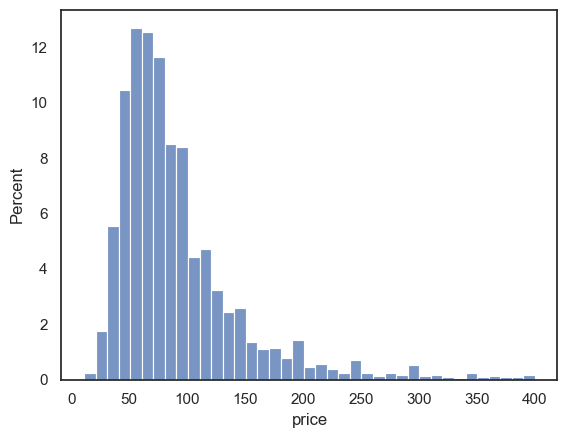

In [7]:
sns.set(style="white")
sns.histplot(
    data = work_df,
    x = 'price', stat='percent', binwidth=10)

In [8]:
categorical_columns = [col for col in work_df.columns if col.startswith("f_")]
numerical_columns = [col for col in work_df.columns if col.startswith("n_") or col.startswith("d_")]

In [9]:
# build interaction terms
# interactions = ['f_property_type*f_room_type',
#                 'n_accommodates*f_property_type',
#                 'n_accommodates*f_room_type',
#                 'f_property_type*f_neighbourhood_cleansed',
#                 'f_room_type*f_neighbourhood_cleansed',
#                 'n_accommodates*f_neighbourhood_cleansed'
#                 ]
interactions = []
for i in categorical_columns + numerical_columns:
    for k in categorical_columns + numerical_columns:
        if i == k:
            continue
        else:
            interactions.append(i + '*' + k)

In [10]:
categorical_columns

['f_neighbourhood_cleansed', 'f_property_type', 'f_room_type']

In [11]:
numerical_columns

['n_accommodates',
 'n_beds',
 'n_minimum_nights',
 'n_maximum_nights',
 'd_host_is_superhost',
 'd_host_has_profile_pic',
 'd_host_identity_verified',
 'd_instant_bookable',
 'n_host_since',
 'n_bathrooms']

In [12]:
data_train, data_holdout = train_test_split(work_df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((12382, 35), (5307, 35))

OLS

In [32]:
# LASSO for OLS
y, X = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns) + '+' + '+'.join(interactions), data_train)
ols_terms_list = X.design_info.column_names
X

DesignMatrix with shape (12382, 2080)
  Columns:
    ['Intercept',
     'f_neighbourhood_cleansed[T.Catania]',
     'f_neighbourhood_cleansed[T.Cefal]',
     'f_neighbourhood_cleansed[T.Gravina di Catania]',
     'f_neighbourhood_cleansed[T.Messina]',
     'f_neighbourhood_cleansed[T.Militello in Val di Catania]',
     'f_neighbourhood_cleansed[T.Modica]',
     'f_neighbourhood_cleansed[T.Monreale]',
     'f_neighbourhood_cleansed[T.Palermo]',
     'f_neighbourhood_cleansed[T.Ragusa]',
     'f_neighbourhood_cleansed[T.Realmonte]',
     'f_neighbourhood_cleansed[T.San Gregorio di Catania]',
     'f_neighbourhood_cleansed[T.Siracusa]',
     'f_neighbourhood_cleansed[T.Taormina]',
     'f_property_type[T.Boat]',
     'f_property_type[T.Camper/RV]',
     'f_property_type[T.Casa particular]',
     'f_property_type[T.Cave]',
     'f_property_type[T.Dammuso]',
     'f_property_type[T.Dome]',
     'f_property_type[T.Earthen home]',
     'f_property_type[T.Entire bed and breakfast]',
     'f_pr

In [33]:
%%time
scaler = StandardScaler()
X = scaler.fit_transform(X)

# define model
lasso_model = ElasticNet(l1_ratio = 1, fit_intercept = True)

# define cv search
ols_search = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 100, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# perform the search
ols_results = ols_search.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END ......................alpha=0.05;, score=-49.101 total time=   9.8s
[CV 2/5] END ......................alpha=0.05;, score=-53.359 total time=  10.5s
[CV 3/5] END ......................alpha=0.05;, score=-49.204 total time=   9.1s
[CV 4/5] END ......................alpha=0.05;, score=-49.306 total time=   9.6s
[CV 5/5] END ......................alpha=0.05;, score=-51.086 total time=  16.8s
[CV 1/5] END .......................alpha=0.1;, score=-48.646 total time=   4.3s
[CV 2/5] END .......................alpha=0.1;, score=-51.453 total time=   3.6s
[CV 3/5] END .......................alpha=0.1;, score=-48.802 total time=   4.3s
[CV 4/5] END .......................alpha=0.1;, score=-48.522 total time=   4.4s
[CV 5/5] END .......................alpha=0.1;, score=-49.302 total time=   3.9s
[CV 1/5] END ......................alpha=0.15;, score=-48.406 total time=   2.6s
[CV 2/5] END ......................alpha=0.15;, 

In [34]:
ols_results.best_estimator_

ElasticNet(alpha=0.4, l1_ratio=1)

In [35]:
ols_results.cv_results_

{'mean_fit_time': array([11.12698236,  4.06706796,  3.23729076,  2.57108297,  1.92270994,
         1.61525412,  1.45690584,  1.34765205,  1.27225986,  1.22864747,
         1.15267825,  1.05743861,  0.99284825,  0.9554347 ,  0.91382518,
         0.89702573,  0.88817763,  0.950106  ,  0.95455499]),
 'std_fit_time': array([2.87761716, 0.31363824, 0.67629807, 0.72392191, 0.2909087 ,
        0.26851163, 0.30326755, 0.23074747, 0.2420675 , 0.25429541,
        0.21124756, 0.14032266, 0.10148638, 0.08160991, 0.0867929 ,
        0.10204289, 0.091518  , 0.19060684, 0.21004781]),
 'mean_score_time': array([0.034095  , 0.03274264, 0.04629984, 0.02550416, 0.02416978,
        0.02280231, 0.02424603, 0.0220603 , 0.02169952, 0.01958151,
        0.01284523, 0.02139525, 0.01838479, 0.01491637, 0.02175651,
        0.01983085, 0.01719823, 0.01607537, 0.01966105]),
 'std_score_time': array([0.00756791, 0.01090351, 0.00819147, 0.00933144, 0.01163927,
        0.0093481 , 0.00825664, 0.00674548, 0.01080198, 0

In [36]:
df_ols_results = pd.DataFrame(ols_results.cv_results_)[['param_alpha', 'rank_test_score', 'mean_test_score']]
df_ols_results

,param_alpha,rank_test_score,mean_test_score
0,0.05,19,-50.411394
1,0.1,18,-49.344984
2,0.15,13,-48.869792
3,0.2,9,-48.781275
4,0.25,6,-48.744064
5,0.3,4,-48.725851
6,0.35,2,-48.706034
7,0.4,1,-48.701629
8,0.45,3,-48.711791
9,0.5,5,-48.732862


In [38]:
pd.DataFrame(
    ols_results.best_estimator_.coef_.tolist(),
    index=ols_terms_list,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_neighbourhood_cleansed[T.Cefal],1.036
f_neighbourhood_cleansed[T.Taormina],1.566
f_property_type[T.Ice dome],0.108
f_property_type[T.Private room in bed and breakfast],3.036
f_property_type[T.Private room in dammuso],0.272
...,...
d_host_is_superhost:d_instant_bookable,-0.073
d_host_has_profile_pic:d_host_identity_verified,-0.818
d_host_has_profile_pic:n_bathrooms,0.552
d_instant_bookable:n_bathrooms,0.868


Random Forest

In [40]:
# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [41]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rfr = RandomForestRegressor(random_state = 42)

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [43]:
rf_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_random)], verbose=True
)

In [58]:
%%time
rf_model = rf_pipe.fit(data_train[numerical_columns + categorical_columns], data_train['price'])
rf_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-49.600 total time=   0.5s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-51.681 total time=   0.5s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-50.312 total time=   0.4s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-48.549 total time=   0.5s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-49.336 total time=   0.4s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-50.389 total time=   0.4s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-52.537 total time=   0.3s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-50.995 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-49.138 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-49.927 total time=   0.4s
[CV 1/5] END max_features=6, min_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'd_host_is_superhost',
                                                   'd_host_has_profile_pic',
                                                   'd_host_identity_verified',
                                                   'd_instant_bookable',
                                                   'n_host_since',
                                                   'n_bathrooms'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [6, 8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [46]:
df_rf_model_cv_results = pd.DataFrame(rf_random.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,49.90,50.60,50.99
8,49.11,49.71,50.08
10,48.66,49.30,49.58
12,48.38,48.98,49.32


In [47]:
rf_random.best_score_

-48.38301678605936

In [48]:
rf_random.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5, random_state=42)

Boosting

In [62]:
gbm = GradientBoostingRegressor(learning_rate=0.01, random_state = 42)

tune_grid = {"n_estimators": [200, 300, 500], "max_depth": [5, 10, 15], "min_samples_leaf": [5, 10, 15], "max_features": [6, 8, 10, 12], 'min_samples_split': [10, 20, 30]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [63]:
%%time
gbm_model = gbm_pipe.fit(data_train[numerical_columns + categorical_columns],data_train.price)
gbm_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 2/5; 2/108] START max_depth=5, max_features=6, min_samples_leaf=5, n_estimators=300
[CV 2/5; 2/108] END max_depth=5, max_features=6, min_samples_leaf=5, n_estimators=300;, score=-51.883 total time=   1.0s
[CV 5/5; 3/108] START max_depth=5, max_features=6, min_samples_leaf=5, n_estimators=500
[CV 5/5; 3/108] END max_depth=5, max_features=6, min_samples_leaf=5, n_estimators=500;, score=-48.319 total time=   1.8s
[CV 2/5; 6/108] START max_depth=5, max_features=6, min_samples_leaf=10, n_estimators=500
[CV 2/5; 6/108] END max_depth=5, max_features=6, min_samples_leaf=10, n_estimators=500;, score=-51.051 total time=   1.7s
[CV 2/5; 8/108] START max_depth=5, max_features=6, min_samples_leaf=15, n_estimators=300
[CV 2/5; 8/108] END max_depth=5, max_features=6, min_samples_leaf=15, n_estimators=300;, score=-52.013 total time=   1.0s
[CV 1/5; 10/108] START ma

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'd_host_is_superhost',
                                                   'd_host_has_profile_pic',
                                                   'd_host_identity_verified',
                                                   'd_instant_bookable',
                                                   'n_host_since',
                                                   'n_bathrooms'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15],
                                          'max_features': [6, 8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15],
                                          'min_samples_split': [10, 20, 30],
                                          'n_estimators': [200, 300, 500]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [64]:
gbm_model_cv.best_score_

-46.69873875722224

In [66]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, max_features=12,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=500, random_state=42)

In [77]:
df_gbm_model_cv_results = pd.DataFrame(gbm_model_cv.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_max_depth', 'param_n_estimators', 'mean_fit_time', 'mean_test_score']]
df_gbm_model_cv_results.columns = ['max features', 'min node size', 'max depth', '# estimators', 'fit time', 'RMSE']
df_gbm_model_cv_results

,max features,min node size,max depth,# estimators,fit time,RMSE
0,6,5,5,200,0.859808,-50.888564
1,6,5,5,300,1.368854,-49.967482
2,6,5,5,500,1.919931,-49.057860
3,6,5,5,200,0.841995,-50.909429
4,6,5,5,300,0.985721,-49.970743
...,...,...,...,...,...,...
319,12,15,15,300,3.556839,-47.829883
320,12,15,15,500,6.527747,-47.250714
321,12,15,15,200,3.176544,-48.459329
322,12,15,15,300,3.912364,-47.829883
